In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc
from importlib import reload

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=10000000, low_quantile=0.005, up_quantile=0.995)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
9841513,2005-06-16,20809,23915,2621,322121,0.005097,0.003630,0.002218
9841514,2005-06-16,20812,47888,7373,541512,-0.023644,0.003630,0.002218
9841515,2005-06-16,20813,69999,6726,525990,-0.002842,0.003630,0.002218
9841516,2005-06-16,20818,16424,3421,332211,-0.000768,0.003630,0.002218


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
            ...   
9205863    2005-02
9333674    2005-03
9481683    2005-04
9622885    2005-05
9764141    2005-06
Name: year_month, Length: 66, dtype: period[M]

In [5]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:19<01:19, 19.83s/it]

Epoch 1/5, Loss: -0.0742, Train Sharpe: 0.0095, Test Sharpe: 0.0512, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [01:00<00:40, 20.05s/it]

Epoch 3/5, Loss: -0.0981, Train Sharpe: 0.0530, Test Sharpe: 0.0706, Avg Weight: 0.0002, Max Weight: 0.0026


Training: 100%|███████████████████████████████████| 5/5 [01:36<00:00, 19.26s/it]

Epoch 5/5, Loss: -0.1136, Train Sharpe: 0.0579, Test Sharpe: 0.0697, Avg Weight: 0.0002, Max Weight: 0.0026
Training completed! Best test Sharpe ratio: 0.0714
Training from 2000-02 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:22<01:30, 22.65s/it]

Epoch 1/5, Loss: -0.0816, Train Sharpe: 0.0208, Test Sharpe: -0.0275, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [01:05<00:43, 21.58s/it]

Epoch 3/5, Loss: -0.1073, Train Sharpe: 0.0481, Test Sharpe: -0.0006, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 5/5 [01:48<00:00, 21.66s/it]

Epoch 5/5, Loss: -0.1215, Train Sharpe: 0.0552, Test Sharpe: 0.0046, Avg Weight: 0.0002, Max Weight: 0.0016
Training completed! Best test Sharpe ratio: 0.0046
Training from 2000-03 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:21<01:24, 21.19s/it]

Epoch 1/5, Loss: -0.0722, Train Sharpe: 0.0244, Test Sharpe: -0.0075, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  60%|█████████████████████              | 3/5 [01:00<00:40, 20.10s/it]

Epoch 3/5, Loss: -0.1121, Train Sharpe: 0.0553, Test Sharpe: 0.0254, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 5/5 [01:44<00:00, 20.92s/it]

Epoch 5/5, Loss: -0.1230, Train Sharpe: 0.0640, Test Sharpe: 0.0285, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0312
Training from 2000-04 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 602 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:23<01:33, 23.41s/it]

Epoch 1/5, Loss: -0.0693, Train Sharpe: 0.0388, Test Sharpe: -0.0357, Avg Weight: 0.0002, Max Weight: 0.0033


Training:  60%|█████████████████████              | 3/5 [01:09<00:45, 22.90s/it]

Epoch 3/5, Loss: -0.1148, Train Sharpe: 0.0623, Test Sharpe: -0.0066, Avg Weight: 0.0002, Max Weight: 0.0041


Training: 100%|███████████████████████████████████| 5/5 [01:52<00:00, 22.56s/it]

Epoch 5/5, Loss: -0.1235, Train Sharpe: 0.0669, Test Sharpe: -0.0034, Avg Weight: 0.0002, Max Weight: 0.0043
Training completed! Best test Sharpe ratio: -0.0029
Training from 2000-05 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 610 train batches, 40 test batches


Training:  20%|███████                            | 1/5 [00:21<01:27, 21.81s/it]

Epoch 1/5, Loss: -0.0580, Train Sharpe: 0.0152, Test Sharpe: 0.0204, Avg Weight: 0.0002, Max Weight: 0.0055


Training:  60%|█████████████████████              | 3/5 [01:03<00:42, 21.07s/it]

Epoch 3/5, Loss: -0.1105, Train Sharpe: 0.0580, Test Sharpe: 0.0428, Avg Weight: 0.0002, Max Weight: 0.0090


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.33s/it]

Epoch 5/5, Loss: -0.1204, Train Sharpe: 0.0618, Test Sharpe: 0.0420, Avg Weight: 0.0002, Max Weight: 0.0093
Training completed! Best test Sharpe ratio: 0.0428
Training from 2000-06 to 2000-12. Testing on 2001-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 600 train batches, 42 test batches


Training:  20%|███████                            | 1/5 [00:18<01:15, 18.95s/it]

Epoch 1/5, Loss: -0.0756, Train Sharpe: 0.0287, Test Sharpe: 0.1070, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  60%|█████████████████████              | 3/5 [00:58<00:39, 19.71s/it]

Epoch 3/5, Loss: -0.1158, Train Sharpe: 0.0544, Test Sharpe: 0.0989, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.32s/it]

Epoch 5/5, Loss: -0.1227, Train Sharpe: 0.0580, Test Sharpe: 0.0936, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.1070
Training from 2000-07 to 2001-01. Testing on 2001-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 594 train batches, 38 test batches


Training:  20%|███████                            | 1/5 [00:19<01:19, 19.99s/it]

Epoch 1/5, Loss: -0.0780, Train Sharpe: 0.0054, Test Sharpe: -0.0736, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  60%|█████████████████████              | 3/5 [01:02<00:41, 20.86s/it]

Epoch 3/5, Loss: -0.1187, Train Sharpe: 0.0391, Test Sharpe: -0.0377, Avg Weight: 0.0002, Max Weight: 0.0020


Training: 100%|███████████████████████████████████| 5/5 [01:39<00:00, 19.92s/it]

Epoch 5/5, Loss: -0.1275, Train Sharpe: 0.0487, Test Sharpe: -0.0336, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: -0.0336
Training from 2000-08 to 2001-02. Testing on 2001-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 587 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:18<01:14, 18.70s/it]

Epoch 1/5, Loss: -0.0704, Train Sharpe: 0.0133, Test Sharpe: -0.0312, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  60%|█████████████████████              | 3/5 [00:59<00:40, 20.19s/it]

Epoch 3/5, Loss: -0.1124, Train Sharpe: 0.0593, Test Sharpe: 0.0207, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 5/5 [01:39<00:00, 19.83s/it]

Epoch 5/5, Loss: -0.1238, Train Sharpe: 0.0659, Test Sharpe: 0.0236, Avg Weight: 0.0002, Max Weight: 0.0029
Training completed! Best test Sharpe ratio: 0.0236
Training from 2000-09 to 2001-03. Testing on 2001-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 579 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:18<01:12, 18.12s/it]

Epoch 1/5, Loss: -0.0606, Train Sharpe: 0.0159, Test Sharpe: 0.0465, Avg Weight: 0.0002, Max Weight: 0.0034


Training:  60%|█████████████████████              | 3/5 [01:00<00:41, 20.72s/it]

Epoch 3/5, Loss: -0.1067, Train Sharpe: 0.0573, Test Sharpe: 0.0696, Avg Weight: 0.0002, Max Weight: 0.0058


Training: 100%|███████████████████████████████████| 5/5 [01:43<00:00, 20.61s/it]

Epoch 5/5, Loss: -0.1179, Train Sharpe: 0.0608, Test Sharpe: 0.0686, Avg Weight: 0.0002, Max Weight: 0.0058
Training completed! Best test Sharpe ratio: 0.0696
Training from 2000-10 to 2001-04. Testing on 2001-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 574 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:19<01:17, 19.25s/it]

Epoch 1/5, Loss: -0.0705, Train Sharpe: 0.0143, Test Sharpe: 0.0069, Avg Weight: 0.0002, Max Weight: 0.3774


Training:  60%|█████████████████████              | 3/5 [00:58<00:38, 19.34s/it]

Epoch 3/5, Loss: -0.1101, Train Sharpe: 0.0442, Test Sharpe: 0.0099, Avg Weight: 0.0002, Max Weight: 0.3390


Training: 100%|███████████████████████████████████| 5/5 [01:36<00:00, 19.32s/it]

Epoch 5/5, Loss: -0.1198, Train Sharpe: 0.0507, Test Sharpe: 0.0121, Avg Weight: 0.0002, Max Weight: 0.2814
Training completed! Best test Sharpe ratio: 0.0121
Training from 2000-11 to 2001-05. Testing on 2001-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 569 train batches, 40 test batches


Training:  20%|███████                            | 1/5 [00:20<01:20, 20.11s/it]

Epoch 1/5, Loss: -0.0739, Train Sharpe: 0.0141, Test Sharpe: 0.0088, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  60%|█████████████████████              | 3/5 [00:59<00:39, 19.65s/it]

Epoch 3/5, Loss: -0.1169, Train Sharpe: 0.0518, Test Sharpe: 0.0298, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 5/5 [01:37<00:00, 19.42s/it]

Epoch 5/5, Loss: -0.1266, Train Sharpe: 0.0559, Test Sharpe: 0.0309, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0309
Training from 2000-12 to 2001-06. Testing on 2001-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 564 train batches, 40 test batches


Training:  20%|███████                            | 1/5 [00:17<01:09, 17.47s/it]

Epoch 1/5, Loss: -0.0841, Train Sharpe: 0.0306, Test Sharpe: -0.0249, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  60%|█████████████████████              | 3/5 [00:55<00:36, 18.45s/it]

Epoch 3/5, Loss: -0.1220, Train Sharpe: 0.0640, Test Sharpe: 0.0080, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 5/5 [01:32<00:00, 18.53s/it]

Epoch 5/5, Loss: -0.1301, Train Sharpe: 0.0680, Test Sharpe: 0.0077, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: 0.0080
Training from 2001-01 to 2001-07. Testing on 2001-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 563 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:18<01:13, 18.30s/it]

Epoch 1/5, Loss: -0.0786, Train Sharpe: 0.0312, Test Sharpe: -0.0216, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  60%|█████████████████████              | 3/5 [00:59<00:40, 20.10s/it]

Epoch 3/5, Loss: -0.1158, Train Sharpe: 0.0614, Test Sharpe: 0.0107, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.22s/it]

Epoch 5/5, Loss: -0.1254, Train Sharpe: 0.0662, Test Sharpe: 0.0121, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0167
Training from 2001-02 to 2001-08. Testing on 2001-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 566 train batches, 28 test batches


Training:  20%|███████                            | 1/5 [00:19<01:18, 19.56s/it]

Epoch 1/5, Loss: -0.0694, Train Sharpe: 0.0154, Test Sharpe: -0.0913, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  60%|█████████████████████              | 3/5 [00:59<00:39, 19.75s/it]

Epoch 3/5, Loss: -0.1053, Train Sharpe: 0.0525, Test Sharpe: -0.0445, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|███████████████████████████████████| 5/5 [01:40<00:00, 20.12s/it]

Epoch 5/5, Loss: -0.1168, Train Sharpe: 0.0573, Test Sharpe: -0.0433, Avg Weight: 0.0002, Max Weight: 0.0022
Training completed! Best test Sharpe ratio: -0.0429
Training from 2001-03 to 2001-09. Testing on 2001-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 547 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:17<01:09, 17.38s/it]

Epoch 1/5, Loss: -0.0685, Train Sharpe: 0.0080, Test Sharpe: 0.0399, Avg Weight: 0.0002, Max Weight: 0.0046


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.22s/it]

Epoch 3/5, Loss: -0.1020, Train Sharpe: 0.0422, Test Sharpe: 0.0541, Avg Weight: 0.0002, Max Weight: 0.0198


Training: 100%|███████████████████████████████████| 5/5 [01:30<00:00, 18.05s/it]

Epoch 5/5, Loss: -0.1120, Train Sharpe: 0.0480, Test Sharpe: 0.0561, Avg Weight: 0.0002, Max Weight: 0.0287
Training completed! Best test Sharpe ratio: 0.0563
Training from 2001-04 to 2001-10. Testing on 2001-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 546 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:19<01:19, 19.93s/it]

Epoch 1/5, Loss: -0.0773, Train Sharpe: 0.0097, Test Sharpe: 0.0733, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [00:58<00:38, 19.36s/it]

Epoch 3/5, Loss: -0.1098, Train Sharpe: 0.0381, Test Sharpe: 0.0813, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 5/5 [01:39<00:00, 19.87s/it]

Epoch 5/5, Loss: -0.1165, Train Sharpe: 0.0502, Test Sharpe: 0.0808, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0813
Training from 2001-05 to 2001-11. Testing on 2001-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 545 train batches, 37 test batches


Training:  20%|███████                            | 1/5 [00:18<01:12, 18.01s/it]

Epoch 1/5, Loss: -0.0815, Train Sharpe: 0.0064, Test Sharpe: 0.0585, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [00:56<00:37, 18.89s/it]

Epoch 3/5, Loss: -0.1132, Train Sharpe: 0.0345, Test Sharpe: 0.0773, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.28s/it]

Epoch 5/5, Loss: -0.1200, Train Sharpe: 0.0411, Test Sharpe: 0.0802, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0802
Training from 2001-06 to 2001-12. Testing on 2002-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 534 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:20<01:23, 20.94s/it]

Epoch 1/5, Loss: -0.0829, Train Sharpe: 0.0070, Test Sharpe: 0.0088, Avg Weight: 0.0003, Max Weight: 0.0987


Training:  60%|█████████████████████              | 3/5 [00:54<00:35, 17.89s/it]

Epoch 3/5, Loss: -0.1138, Train Sharpe: 0.0338, Test Sharpe: 0.0182, Avg Weight: 0.0003, Max Weight: 0.1502


Training: 100%|███████████████████████████████████| 5/5 [01:29<00:00, 17.97s/it]

Epoch 5/5, Loss: -0.1194, Train Sharpe: 0.0377, Test Sharpe: 0.0181, Avg Weight: 0.0003, Max Weight: 0.1502
Training completed! Best test Sharpe ratio: 0.0182
Training from 2001-07 to 2002-01. Testing on 2002-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 531 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:19<01:16, 19.09s/it]

Epoch 1/5, Loss: -0.0886, Train Sharpe: 0.0092, Test Sharpe: -0.0296, Avg Weight: 0.0003, Max Weight: 0.0033


Training:  60%|█████████████████████              | 3/5 [00:58<00:39, 19.68s/it]

Epoch 3/5, Loss: -0.1080, Train Sharpe: 0.0415, Test Sharpe: -0.0006, Avg Weight: 0.0003, Max Weight: 0.0031


Training: 100%|███████████████████████████████████| 5/5 [01:34<00:00, 19.00s/it]

Epoch 5/5, Loss: -0.1204, Train Sharpe: 0.0482, Test Sharpe: 0.0075, Avg Weight: 0.0003, Max Weight: 0.0038
Training completed! Best test Sharpe ratio: 0.0075
Training from 2001-08 to 2002-02. Testing on 2002-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 520 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:16<01:07, 16.96s/it]

Epoch 1/5, Loss: -0.0813, Train Sharpe: 0.0052, Test Sharpe: 0.0752, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.31s/it]

Epoch 3/5, Loss: -0.1040, Train Sharpe: 0.0432, Test Sharpe: 0.0882, Avg Weight: 0.0002, Max Weight: 0.0016


Training: 100%|███████████████████████████████████| 5/5 [01:26<00:00, 17.25s/it]

Epoch 5/5, Loss: -0.1169, Train Sharpe: 0.0523, Test Sharpe: 0.0831, Avg Weight: 0.0002, Max Weight: 0.0016
Training completed! Best test Sharpe ratio: 0.0882
Training from 2001-09 to 2002-03. Testing on 2002-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 506 train batches, 40 test batches


Training:  20%|███████                            | 1/5 [00:17<01:09, 17.41s/it]

Epoch 1/5, Loss: -0.1007, Train Sharpe: 0.0215, Test Sharpe: -0.0000, Avg Weight: 0.0002, Max Weight: 0.0035


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.24s/it]

Epoch 3/5, Loss: -0.1014, Train Sharpe: 0.0447, Test Sharpe: 0.0227, Avg Weight: 0.0002, Max Weight: 0.0031


Training: 100%|███████████████████████████████████| 5/5 [01:26<00:00, 17.24s/it]

Epoch 5/5, Loss: -0.1219, Train Sharpe: 0.0509, Test Sharpe: 0.0290, Avg Weight: 0.0002, Max Weight: 0.0030
Training completed! Best test Sharpe ratio: 0.0290
Training from 2001-10 to 2002-04. Testing on 2002-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 529 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:17<01:09, 17.36s/it]

Epoch 1/5, Loss: -0.1024, Train Sharpe: 0.0445, Test Sharpe: -0.0094, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [00:52<00:35, 17.70s/it]

Epoch 3/5, Loss: -0.1350, Train Sharpe: 0.0730, Test Sharpe: 0.0249, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 5/5 [01:36<00:00, 19.27s/it]

Epoch 5/5, Loss: -0.1408, Train Sharpe: 0.0772, Test Sharpe: 0.0270, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0270
Training from 2001-11 to 2002-05. Testing on 2002-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 522 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.17s/it]

Epoch 1/5, Loss: -0.0964, Train Sharpe: 0.0397, Test Sharpe: -0.0403, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  60%|█████████████████████              | 3/5 [00:49<00:33, 16.61s/it]

Epoch 3/5, Loss: -0.1247, Train Sharpe: 0.0676, Test Sharpe: -0.0005, Avg Weight: 0.0002, Max Weight: 0.0051


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.48s/it]

Epoch 5/5, Loss: -0.1353, Train Sharpe: 0.0717, Test Sharpe: 0.0052, Avg Weight: 0.0002, Max Weight: 0.0060
Training completed! Best test Sharpe ratio: 0.0052
Training from 2001-12 to 2002-06. Testing on 2002-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.24s/it]

Epoch 1/5, Loss: -0.0809, Train Sharpe: 0.0262, Test Sharpe: -0.0375, Avg Weight: 0.0002, Max Weight: 0.0035


Training:  60%|█████████████████████              | 3/5 [00:49<00:32, 16.50s/it]

Epoch 3/5, Loss: -0.1124, Train Sharpe: 0.0551, Test Sharpe: 0.0174, Avg Weight: 0.0002, Max Weight: 0.0063


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.45s/it]

Epoch 5/5, Loss: -0.1231, Train Sharpe: 0.0591, Test Sharpe: 0.0162, Avg Weight: 0.0002, Max Weight: 0.0063
Training completed! Best test Sharpe ratio: 0.0174
Training from 2002-01 to 2002-07. Testing on 2002-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 520 train batches, 39 test batches


Training:  20%|███████                            | 1/5 [00:16<01:05, 16.33s/it]

Epoch 1/5, Loss: -0.0660, Train Sharpe: 0.0087, Test Sharpe: 0.0096, Avg Weight: 0.0002, Max Weight: 0.0271


Training:  60%|█████████████████████              | 3/5 [00:49<00:32, 16.38s/it]

Epoch 3/5, Loss: -0.1022, Train Sharpe: 0.0484, Test Sharpe: 0.0559, Avg Weight: 0.0002, Max Weight: 0.0109


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.42s/it]

Epoch 5/5, Loss: -0.1136, Train Sharpe: 0.0504, Test Sharpe: 0.0567, Avg Weight: 0.0002, Max Weight: 0.0123
Training completed! Best test Sharpe ratio: 0.0567
Training from 2002-02 to 2002-08. Testing on 2002-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 521 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.11s/it]

Epoch 1/5, Loss: -0.0636, Train Sharpe: 0.0004, Test Sharpe: -0.0630, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  60%|█████████████████████              | 3/5 [00:48<00:32, 16.21s/it]

Epoch 3/5, Loss: -0.1001, Train Sharpe: 0.0426, Test Sharpe: -0.0071, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 5/5 [01:21<00:00, 16.21s/it]

Epoch 5/5, Loss: -0.1135, Train Sharpe: 0.0501, Test Sharpe: 0.0037, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.0037
Training from 2002-03 to 2002-09. Testing on 2002-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 522 train batches, 40 test batches


Training:  20%|███████                            | 1/5 [00:16<01:05, 16.33s/it]

Epoch 1/5, Loss: -0.0636, Train Sharpe: 0.0076, Test Sharpe: 0.0294, Avg Weight: 0.0002, Max Weight: 0.0027


Training:  60%|█████████████████████              | 3/5 [00:49<00:32, 16.35s/it]

Epoch 3/5, Loss: -0.0969, Train Sharpe: 0.0473, Test Sharpe: 0.0742, Avg Weight: 0.0002, Max Weight: 0.0058


Training: 100%|███████████████████████████████████| 5/5 [01:21<00:00, 16.33s/it]

Epoch 5/5, Loss: -0.1110, Train Sharpe: 0.0502, Test Sharpe: 0.0729, Avg Weight: 0.0002, Max Weight: 0.0062
Training completed! Best test Sharpe ratio: 0.0752
Training from 2002-04 to 2002-10. Testing on 2002-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 530 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.75s/it]

Epoch 1/5, Loss: -0.0500, Train Sharpe: -0.0063, Test Sharpe: 0.0897, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  60%|█████████████████████              | 3/5 [00:49<00:33, 16.60s/it]

Epoch 3/5, Loss: -0.0973, Train Sharpe: 0.0263, Test Sharpe: 0.1000, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.54s/it]

Epoch 5/5, Loss: -0.1089, Train Sharpe: 0.0353, Test Sharpe: 0.0947, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: 0.1032
Training from 2002-05 to 2002-11. Testing on 2002-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 521 train batches, 37 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.75s/it]

Epoch 1/5, Loss: -0.0637, Train Sharpe: -0.0082, Test Sharpe: -0.0339, Avg Weight: 0.0003, Max Weight: 0.0047


Training:  60%|█████████████████████              | 3/5 [00:49<00:32, 16.32s/it]

Epoch 3/5, Loss: -0.0974, Train Sharpe: 0.0224, Test Sharpe: -0.0061, Avg Weight: 0.0003, Max Weight: 0.0044


Training: 100%|███████████████████████████████████| 5/5 [01:21<00:00, 16.38s/it]

Epoch 5/5, Loss: -0.1133, Train Sharpe: 0.0299, Test Sharpe: -0.0024, Avg Weight: 0.0003, Max Weight: 0.0043
Training completed! Best test Sharpe ratio: -0.0024
Training from 2002-06 to 2002-12. Testing on 2003-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 515 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:15<01:03, 15.91s/it]

Epoch 1/5, Loss: -0.0573, Train Sharpe: -0.0104, Test Sharpe: 0.0065, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  60%|█████████████████████              | 3/5 [00:48<00:32, 16.26s/it]

Epoch 3/5, Loss: -0.0867, Train Sharpe: 0.0399, Test Sharpe: 0.0397, Avg Weight: 0.0002, Max Weight: 0.0027


Training: 100%|███████████████████████████████████| 5/5 [01:20<00:00, 16.12s/it]

Epoch 5/5, Loss: -0.1109, Train Sharpe: 0.0501, Test Sharpe: 0.0479, Avg Weight: 0.0002, Max Weight: 0.0030
Training completed! Best test Sharpe ratio: 0.0479
Training from 2002-07 to 2003-01. Testing on 2003-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 33 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.16s/it]

Epoch 1/5, Loss: -0.0658, Train Sharpe: -0.0001, Test Sharpe: -0.0176, Avg Weight: 0.0002, Max Weight: 0.0026


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.86s/it]

Epoch 3/5, Loss: -0.0980, Train Sharpe: 0.0513, Test Sharpe: 0.0284, Avg Weight: 0.0002, Max Weight: 0.0062


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.98s/it]

Epoch 5/5, Loss: -0.1157, Train Sharpe: 0.0561, Test Sharpe: 0.0315, Avg Weight: 0.0002, Max Weight: 0.0092
Training completed! Best test Sharpe ratio: 0.0315
Training from 2002-08 to 2003-02. Testing on 2003-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 503 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:15<01:02, 15.71s/it]

Epoch 1/5, Loss: -0.0693, Train Sharpe: 0.0110, Test Sharpe: 0.0150, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.92s/it]

Epoch 3/5, Loss: -0.1057, Train Sharpe: 0.0589, Test Sharpe: 0.0476, Avg Weight: 0.0002, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.93s/it]

Epoch 5/5, Loss: -0.1203, Train Sharpe: 0.0607, Test Sharpe: 0.0484, Avg Weight: 0.0002, Max Weight: 0.0041
Training completed! Best test Sharpe ratio: 0.0495
Training from 2002-09 to 2003-03. Testing on 2003-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 497 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:15<01:02, 15.58s/it]

Epoch 1/5, Loss: -0.0703, Train Sharpe: 0.0132, Test Sharpe: 0.0931, Avg Weight: 0.0003, Max Weight: 0.0040


Training:  60%|█████████████████████              | 3/5 [00:52<00:36, 18.04s/it]

Epoch 3/5, Loss: -0.1086, Train Sharpe: 0.0539, Test Sharpe: 0.0951, Avg Weight: 0.0003, Max Weight: 0.0056


Training: 100%|███████████████████████████████████| 5/5 [01:26<00:00, 17.23s/it]

Epoch 5/5, Loss: -0.1193, Train Sharpe: 0.0594, Test Sharpe: 0.0834, Avg Weight: 0.0003, Max Weight: 0.0056
Training completed! Best test Sharpe ratio: 0.0986
Training from 2002-10 to 2003-04. Testing on 2003-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 498 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.08s/it]

Epoch 1/5, Loss: -0.0849, Train Sharpe: 0.0341, Test Sharpe: 0.1230, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.92s/it]

Epoch 3/5, Loss: -0.1139, Train Sharpe: 0.0572, Test Sharpe: 0.1333, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 5/5 [01:20<00:00, 16.04s/it]

Epoch 5/5, Loss: -0.1336, Train Sharpe: 0.0653, Test Sharpe: 0.1296, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.1333
Training from 2002-11 to 2003-05. Testing on 2003-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 489 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:15<01:03, 15.83s/it]

Epoch 1/5, Loss: -0.1059, Train Sharpe: 0.0456, Test Sharpe: 0.0532, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.64s/it]

Epoch 3/5, Loss: -0.1324, Train Sharpe: 0.0609, Test Sharpe: 0.0623, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 5/5 [01:18<00:00, 15.69s/it]

Epoch 5/5, Loss: -0.1448, Train Sharpe: 0.0668, Test Sharpe: 0.0670, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0670
Training from 2002-12 to 2003-06. Testing on 2003-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 489 train batches, 37 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.02s/it]

Epoch 1/5, Loss: -0.1023, Train Sharpe: 0.0376, Test Sharpe: 0.0628, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.92s/it]

Epoch 3/5, Loss: -0.1171, Train Sharpe: 0.0555, Test Sharpe: 0.0730, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.93s/it]

Epoch 5/5, Loss: -0.1348, Train Sharpe: 0.0617, Test Sharpe: 0.0760, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0760
Training from 2003-01 to 2003-07. Testing on 2003-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 490 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:15<01:03, 15.90s/it]

Epoch 1/5, Loss: -0.1132, Train Sharpe: 0.0540, Test Sharpe: 0.0622, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  60%|█████████████████████              | 3/5 [00:56<00:39, 19.83s/it]

Epoch 3/5, Loss: -0.1365, Train Sharpe: 0.0677, Test Sharpe: 0.0729, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 5/5 [01:27<00:00, 17.48s/it]

Epoch 5/5, Loss: -0.1468, Train Sharpe: 0.0742, Test Sharpe: 0.0753, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0753
Training from 2003-02 to 2003-08. Testing on 2003-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 487 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.14s/it]

Epoch 1/5, Loss: -0.1266, Train Sharpe: 0.0620, Test Sharpe: 0.0287, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.77s/it]

Epoch 3/5, Loss: -0.1412, Train Sharpe: 0.0762, Test Sharpe: 0.0348, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 5/5 [01:18<00:00, 15.74s/it]

Epoch 5/5, Loss: -0.1528, Train Sharpe: 0.0797, Test Sharpe: 0.0399, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0399
Training from 2003-03 to 2003-09. Testing on 2003-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 491 train batches, 38 test batches


Training:  20%|███████                            | 1/5 [00:15<01:02, 15.56s/it]

Epoch 1/5, Loss: -0.1360, Train Sharpe: 0.0696, Test Sharpe: 0.0941, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.78s/it]

Epoch 3/5, Loss: -0.1467, Train Sharpe: 0.0837, Test Sharpe: 0.0995, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 5/5 [01:18<00:00, 15.74s/it]

Epoch 5/5, Loss: -0.1587, Train Sharpe: 0.0892, Test Sharpe: 0.0974, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.1001
Training from 2003-04 to 2003-10. Testing on 2003-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 496 train batches, 32 test batches


Training:  20%|███████                            | 1/5 [00:16<01:05, 16.40s/it]

Epoch 1/5, Loss: -0.1425, Train Sharpe: 0.0825, Test Sharpe: 0.0501, Avg Weight: 0.0003, Max Weight: 0.0089


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.81s/it]

Epoch 3/5, Loss: -0.1595, Train Sharpe: 0.0859, Test Sharpe: 0.0492, Avg Weight: 0.0003, Max Weight: 0.0089


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.82s/it]

Epoch 5/5, Loss: -0.1678, Train Sharpe: 0.0960, Test Sharpe: 0.0549, Avg Weight: 0.0003, Max Weight: 0.0126
Training completed! Best test Sharpe ratio: 0.0549
Training from 2003-05 to 2003-11. Testing on 2003-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 488 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:15<01:02, 15.55s/it]

Epoch 1/5, Loss: -0.1435, Train Sharpe: 0.0748, Test Sharpe: 0.0510, Avg Weight: 0.0002, Max Weight: 0.0004


Training:  60%|█████████████████████              | 3/5 [00:46<00:31, 15.58s/it]

Epoch 3/5, Loss: -0.1527, Train Sharpe: 0.0795, Test Sharpe: 0.0526, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 5/5 [01:17<00:00, 15.57s/it]

Epoch 5/5, Loss: -0.1603, Train Sharpe: 0.0865, Test Sharpe: 0.0611, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0611
Training from 2003-06 to 2003-12. Testing on 2004-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 489 train batches, 33 test batches


Training:  20%|███████                            | 1/5 [00:15<01:01, 15.43s/it]

Epoch 1/5, Loss: -0.1277, Train Sharpe: 0.0636, Test Sharpe: 0.0850, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.48s/it]

Epoch 3/5, Loss: -0.1403, Train Sharpe: 0.0651, Test Sharpe: 0.0850, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 5/5 [01:17<00:00, 15.58s/it]

Epoch 5/5, Loss: -0.1437, Train Sharpe: 0.0718, Test Sharpe: 0.0865, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0865
Training from 2003-07 to 2004-01. Testing on 2004-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 485 train batches, 32 test batches


Training:  20%|███████                            | 1/5 [00:15<01:01, 15.36s/it]

Epoch 1/5, Loss: -0.1343, Train Sharpe: 0.0683, Test Sharpe: 0.0247, Avg Weight: 0.0003, Max Weight: 0.0050


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.36s/it]

Epoch 3/5, Loss: -0.1458, Train Sharpe: 0.0690, Test Sharpe: 0.0243, Avg Weight: 0.0003, Max Weight: 0.0050


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.35s/it]

Epoch 5/5, Loss: -0.1479, Train Sharpe: 0.0722, Test Sharpe: 0.0272, Avg Weight: 0.0003, Max Weight: 0.0071
Training completed! Best test Sharpe ratio: 0.0272
Training from 2003-08 to 2004-02. Testing on 2004-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 475 train batches, 38 test batches


Training:  20%|███████                            | 1/5 [00:15<01:00, 15.10s/it]

Epoch 1/5, Loss: -0.1276, Train Sharpe: 0.0637, Test Sharpe: 0.0092, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  60%|█████████████████████              | 3/5 [00:45<00:30, 15.23s/it]

Epoch 3/5, Loss: -0.1412, Train Sharpe: 0.0672, Test Sharpe: 0.0105, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.24s/it]

Epoch 5/5, Loss: -0.1456, Train Sharpe: 0.0741, Test Sharpe: 0.0212, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0212
Training from 2003-09 to 2004-03. Testing on 2004-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:15<01:01, 15.35s/it]

Epoch 1/5, Loss: -0.1206, Train Sharpe: 0.0539, Test Sharpe: -0.0571, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.45s/it]

Epoch 3/5, Loss: -0.1307, Train Sharpe: 0.0575, Test Sharpe: -0.0618, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 5/5 [01:17<00:00, 15.44s/it]

Epoch 5/5, Loss: -0.1346, Train Sharpe: 0.0652, Test Sharpe: -0.0547, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: -0.0547
Training from 2003-10 to 2004-04. Testing on 2004-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 33 test batches


Training:  20%|███████                            | 1/5 [00:15<01:00, 15.20s/it]

Epoch 1/5, Loss: -0.1119, Train Sharpe: 0.0034, Test Sharpe: 0.0006, Avg Weight: 0.0002, Max Weight: 0.1984


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.44s/it]

Epoch 3/5, Loss: -0.1123, Train Sharpe: 0.0279, Test Sharpe: 0.0021, Avg Weight: 0.0002, Max Weight: 0.0058


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.35s/it]

Epoch 5/5, Loss: -0.1143, Train Sharpe: 0.0360, Test Sharpe: 0.0060, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0060
Training from 2003-11 to 2004-05. Testing on 2004-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 471 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:18<01:12, 18.21s/it]

Epoch 1/5, Loss: -0.0892, Train Sharpe: 0.0197, Test Sharpe: 0.0306, Avg Weight: 0.0002, Max Weight: 0.0032


Training:  60%|█████████████████████              | 3/5 [00:48<00:31, 15.98s/it]

Epoch 3/5, Loss: -0.0985, Train Sharpe: 0.0246, Test Sharpe: 0.0360, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.83s/it]

Epoch 5/5, Loss: -0.0974, Train Sharpe: 0.0245, Test Sharpe: 0.0364, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0364
Training from 2003-12 to 2004-06. Testing on 2004-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 477 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:15<01:02, 15.72s/it]

Epoch 1/5, Loss: -0.0889, Train Sharpe: 0.0226, Test Sharpe: -0.0624, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  60%|█████████████████████              | 3/5 [00:46<00:31, 15.53s/it]

Epoch 3/5, Loss: -0.0962, Train Sharpe: 0.0232, Test Sharpe: -0.0621, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 5/5 [01:17<00:00, 15.58s/it]

Epoch 5/5, Loss: -0.0984, Train Sharpe: 0.0274, Test Sharpe: -0.0595, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: -0.0595
Training from 2004-01 to 2004-07. Testing on 2004-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 474 train batches, 36 test batches


Training:  20%|███████                            | 1/5 [00:15<01:01, 15.37s/it]

Epoch 1/5, Loss: -0.0719, Train Sharpe: 0.0020, Test Sharpe: -0.0000, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  60%|█████████████████████              | 3/5 [00:45<00:30, 15.26s/it]

Epoch 3/5, Loss: -0.0779, Train Sharpe: 0.0118, Test Sharpe: 0.0105, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 5/5 [01:17<00:00, 15.47s/it]

Epoch 5/5, Loss: -0.0882, Train Sharpe: 0.0247, Test Sharpe: 0.0286, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0286
Training from 2004-02 to 2004-08. Testing on 2004-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:07, 16.95s/it]

Epoch 1/5, Loss: -0.0653, Train Sharpe: -0.0012, Test Sharpe: 0.0493, Avg Weight: 0.0002, Max Weight: 0.0048


Training:  60%|█████████████████████              | 3/5 [00:53<00:35, 17.87s/it]

Epoch 3/5, Loss: -0.0746, Train Sharpe: 0.0066, Test Sharpe: 0.0523, Avg Weight: 0.0002, Max Weight: 0.0047


Training: 100%|███████████████████████████████████| 5/5 [01:28<00:00, 17.69s/it]

Epoch 5/5, Loss: -0.0832, Train Sharpe: 0.0183, Test Sharpe: 0.0519, Avg Weight: 0.0002, Max Weight: 0.0047
Training completed! Best test Sharpe ratio: 0.0545
Training from 2004-03 to 2004-09. Testing on 2004-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 487 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:17<01:08, 17.19s/it]

Epoch 1/5, Loss: -0.0696, Train Sharpe: -0.0008, Test Sharpe: 0.0336, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.23s/it]

Epoch 3/5, Loss: -0.0761, Train Sharpe: 0.0077, Test Sharpe: 0.0359, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|███████████████████████████████████| 5/5 [01:25<00:00, 17.14s/it]

Epoch 5/5, Loss: -0.0822, Train Sharpe: 0.0204, Test Sharpe: 0.0408, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0408
Training from 2004-04 to 2004-10. Testing on 2004-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.61s/it]

Epoch 1/5, Loss: -0.0772, Train Sharpe: 0.0031, Test Sharpe: 0.0968, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.11s/it]

Epoch 3/5, Loss: -0.0744, Train Sharpe: 0.0039, Test Sharpe: 0.0978, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 5/5 [01:25<00:00, 17.07s/it]

Epoch 5/5, Loss: -0.0852, Train Sharpe: 0.0159, Test Sharpe: 0.0952, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.1001
Training from 2004-05 to 2004-11. Testing on 2004-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 37 test batches


Training:  20%|███████                            | 1/5 [00:17<01:08, 17.10s/it]

Epoch 1/5, Loss: -0.0989, Train Sharpe: 0.0272, Test Sharpe: 0.0696, Avg Weight: 0.0003, Max Weight: 0.0028


Training:  60%|█████████████████████              | 3/5 [00:51<00:34, 17.13s/it]

Epoch 3/5, Loss: -0.1089, Train Sharpe: 0.0315, Test Sharpe: 0.0704, Avg Weight: 0.0003, Max Weight: 0.0033


Training: 100%|███████████████████████████████████| 5/5 [01:27<00:00, 17.47s/it]

Epoch 5/5, Loss: -0.1173, Train Sharpe: 0.0414, Test Sharpe: 0.0754, Avg Weight: 0.0003, Max Weight: 0.0034
Training completed! Best test Sharpe ratio: 0.0754
Training from 2004-06 to 2004-12. Testing on 2005-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 488 train batches, 33 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.65s/it]

Epoch 1/5, Loss: -0.1115, Train Sharpe: 0.0375, Test Sharpe: -0.0463, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  60%|█████████████████████              | 3/5 [00:52<00:35, 17.75s/it]

Epoch 3/5, Loss: -0.1163, Train Sharpe: 0.0399, Test Sharpe: -0.0460, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 5/5 [01:27<00:00, 17.57s/it]

Epoch 5/5, Loss: -0.1261, Train Sharpe: 0.0467, Test Sharpe: -0.0421, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: -0.0421
Training from 2004-07 to 2005-01. Testing on 2005-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 485 train batches, 32 test batches


Training:  20%|███████                            | 1/5 [00:25<01:42, 25.73s/it]

Epoch 1/5, Loss: -0.0960, Train Sharpe: 0.0272, Test Sharpe: 0.0253, Avg Weight: 0.0003, Max Weight: 0.0020


Training:  60%|█████████████████████              | 3/5 [01:00<00:38, 19.42s/it]

Epoch 3/5, Loss: -0.1086, Train Sharpe: 0.0357, Test Sharpe: 0.0262, Avg Weight: 0.0003, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 5/5 [01:33<00:00, 18.76s/it]

Epoch 5/5, Loss: -0.1197, Train Sharpe: 0.0481, Test Sharpe: 0.0345, Avg Weight: 0.0003, Max Weight: 0.0026
Training completed! Best test Sharpe ratio: 0.0345
Training from 2004-08 to 2005-02. Testing on 2005-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 479 train batches, 37 test batches


Training:  20%|███████                            | 1/5 [00:19<01:18, 19.61s/it]

Epoch 1/5, Loss: -0.1103, Train Sharpe: 0.0416, Test Sharpe: -0.0420, Avg Weight: 0.0002, Max Weight: 0.0045


Training:  60%|█████████████████████              | 3/5 [00:54<00:35, 17.88s/it]

Epoch 3/5, Loss: -0.1206, Train Sharpe: 0.0478, Test Sharpe: -0.0369, Avg Weight: 0.0002, Max Weight: 0.0042


Training: 100%|███████████████████████████████████| 5/5 [01:27<00:00, 17.43s/it]

Epoch 5/5, Loss: -0.1274, Train Sharpe: 0.0561, Test Sharpe: -0.0278, Avg Weight: 0.0002, Max Weight: 0.0040
Training completed! Best test Sharpe ratio: -0.0278
Training from 2004-09 to 2005-03. Testing on 2005-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 479 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:18<01:15, 18.98s/it]

Epoch 1/5, Loss: -0.1024, Train Sharpe: 0.0223, Test Sharpe: -0.0342, Avg Weight: 0.0002, Max Weight: 0.0036


Training:  60%|█████████████████████              | 3/5 [00:54<00:36, 18.10s/it]

Epoch 3/5, Loss: -0.1085, Train Sharpe: 0.0362, Test Sharpe: -0.0396, Avg Weight: 0.0002, Max Weight: 0.0068


Training: 100%|███████████████████████████████████| 5/5 [01:26<00:00, 17.36s/it]

Epoch 5/5, Loss: -0.1174, Train Sharpe: 0.0453, Test Sharpe: -0.0311, Avg Weight: 0.0002, Max Weight: 0.0068
Training completed! Best test Sharpe ratio: -0.0249
Training from 2004-10 to 2005-04. Testing on 2005-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 480 train batches, 35 test batches


Training:  20%|███████                            | 1/5 [00:16<01:04, 16.04s/it]

Epoch 1/5, Loss: -0.0840, Train Sharpe: 0.0050, Test Sharpe: 0.0282, Avg Weight: 0.0002, Max Weight: 0.0115


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 16.00s/it]

Epoch 3/5, Loss: -0.0861, Train Sharpe: 0.0096, Test Sharpe: 0.0343, Avg Weight: 0.0002, Max Weight: 0.0129


Training: 100%|███████████████████████████████████| 5/5 [01:22<00:00, 16.42s/it]

Epoch 5/5, Loss: -0.0907, Train Sharpe: 0.0145, Test Sharpe: 0.0320, Avg Weight: 0.0002, Max Weight: 0.0129
Training completed! Best test Sharpe ratio: 0.0343
Training from 2004-11 to 2005-05. Testing on 2005-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 480 train batches, 19 test batches


Training:  20%|███████                            | 1/5 [00:15<01:03, 15.77s/it]

Epoch 1/5, Loss: -0.0833, Train Sharpe: 0.0172, Test Sharpe: 0.0813, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  60%|█████████████████████              | 3/5 [00:47<00:31, 15.84s/it]

Epoch 3/5, Loss: -0.0895, Train Sharpe: 0.0208, Test Sharpe: 0.0748, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 5/5 [01:19<00:00, 15.93s/it]

Epoch 5/5, Loss: -0.0969, Train Sharpe: 0.0278, Test Sharpe: 0.0871, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0871


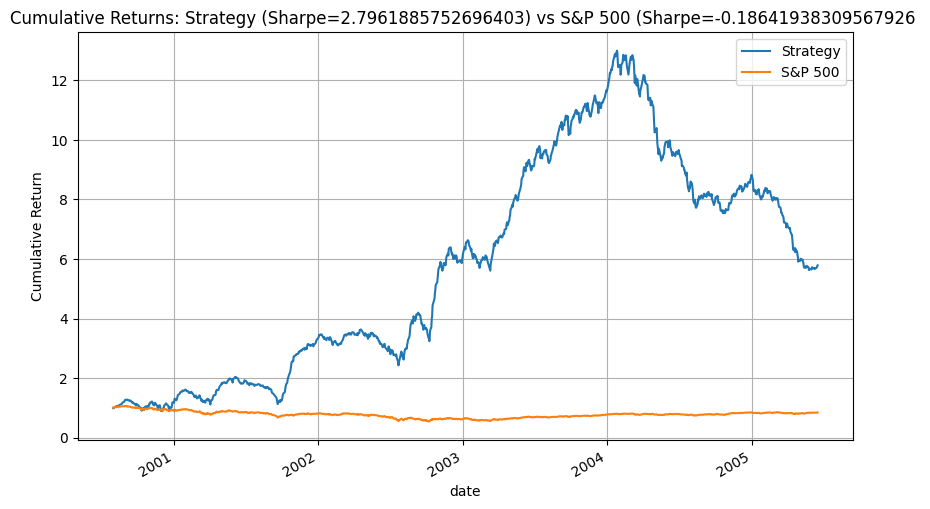

In [6]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[7].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

In [22]:
end_date = sp_ret.index.max()
end_date

Timestamp('2005-06-16 00:00:00')

In [27]:
regression = pd.read_csv('base_benchmark_regul.csv', usecols=['date', 'cumulative_1dollar'])
regression['date'] = pd.to_datetime(regression['date'], format="%Y-%m-%d")
regression = regression.loc[regression['date'] <= end_date]
regression = regression.set_index('date')
regression

,cumulative_1dollar
date,
2000-07-03,0.997942
2000-07-05,0.997489
2000-07-06,0.996326
2000-07-07,1.000691
2000-07-10,1.013719
...,...
2005-06-10,2.359190
2005-06-13,2.365178
2005-06-14,2.375978


In [36]:
type(pd.Series(regression['cumulative_1dollar']))

pandas.core.series.Series

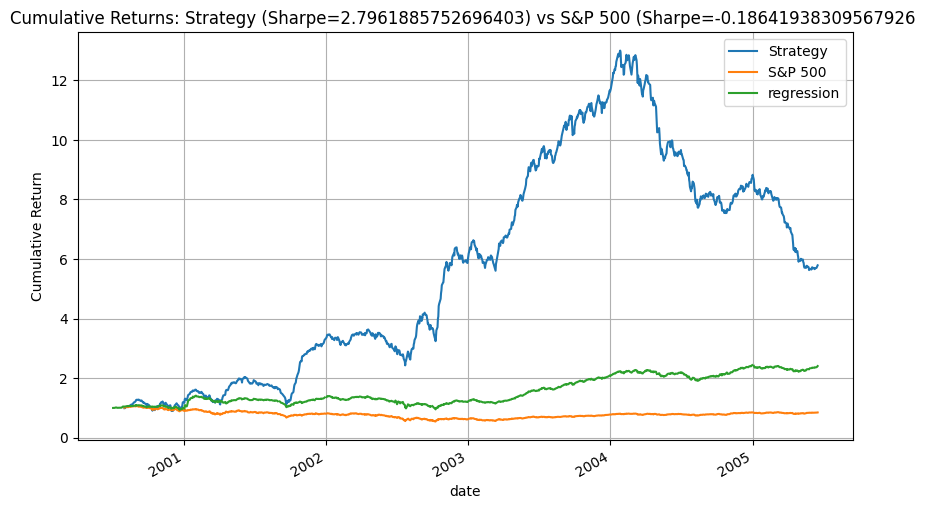

In [38]:
# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500,
    'regression': pd.Series(regression['cumulative_1dollar'])
})

# Sharpe ratio
strat_sharpe = np.sqrt(combined_returns.shape[0]) * (combined_returns.mean() / combined_returns.std())
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



In [41]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, 11 - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.20% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    #test_df['tc_cost'] = test_df['weight_change'].apply(utils.progressive_cost) * TC_RATE # Apply increasing costs relative to trade size
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:21<01:25, 21.42s/it]

Epoch 1/5, Loss: -0.0712, Train Sharpe: 0.0113, Test Sharpe: 0.0421, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [01:01<00:41, 20.59s/it]

Epoch 3/5, Loss: -0.1039, Train Sharpe: 0.0555, Test Sharpe: 0.0652, Avg Weight: 0.0002, Max Weight: 0.0026


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.24s/it]

Epoch 5/5, Loss: -0.1168, Train Sharpe: 0.0623, Test Sharpe: 0.0654, Avg Weight: 0.0002, Max Weight: 0.0049
Training completed! Best test Sharpe ratio: 0.0654


Training from 2000-02 to 2000-08. Testing on 2000-09.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:22<01:28, 22.04s/it]

Epoch 1/5, Loss: -0.0803, Train Sharpe: 0.0168, Test Sharpe: -0.0304, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [01:10<00:46, 23.44s/it]

Epoch 3/5, Loss: -0.1010, Train Sharpe: 0.0457, Test Sharpe: 0.0085, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 5/5 [01:53<00:00, 22.79s/it]

Epoch 5/5, Loss: -0.1198, Train Sharpe: 0.0539, Test Sharpe: 0.0159, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0159


Training from 2000-03 to 2000-09. Testing on 2000-10.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:21<01:27, 22.00s/it]

Epoch 1/5, Loss: -0.0682, Train Sharpe: 0.0094, Test Sharpe: -0.0219, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  60%|█████████████████████              | 3/5 [01:05<00:43, 21.74s/it]

Epoch 3/5, Loss: -0.1100, Train Sharpe: 0.0552, Test Sharpe: 0.0319, Avg Weight: 0.0002, Max Weight: 0.0029


Training: 100%|███████████████████████████████████| 5/5 [01:51<00:00, 22.26s/it]

Epoch 5/5, Loss: -0.1225, Train Sharpe: 0.0646, Test Sharpe: 0.0368, Avg Weight: 0.0002, Max Weight: 0.0037
Training completed! Best test Sharpe ratio: 0.0378


Training from 2000-04 to 2000-10. Testing on 2000-11.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 602 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:23<01:32, 23.13s/it]

Epoch 1/5, Loss: -0.0684, Train Sharpe: 0.0162, Test Sharpe: -0.0626, Avg Weight: 0.0002, Max Weight: 0.0031


Training:  60%|█████████████████████              | 3/5 [01:09<00:46, 23.42s/it]

Epoch 3/5, Loss: -0.1134, Train Sharpe: 0.0620, Test Sharpe: -0.0137, Avg Weight: 0.0002, Max Weight: 0.0038


Training: 100%|███████████████████████████████████| 5/5 [01:57<00:00, 23.58s/it]

Epoch 5/5, Loss: -0.1237, Train Sharpe: 0.0671, Test Sharpe: -0.0064, Avg Weight: 0.0002, Max Weight: 0.0041
Training completed! Best test Sharpe ratio: -0.0064


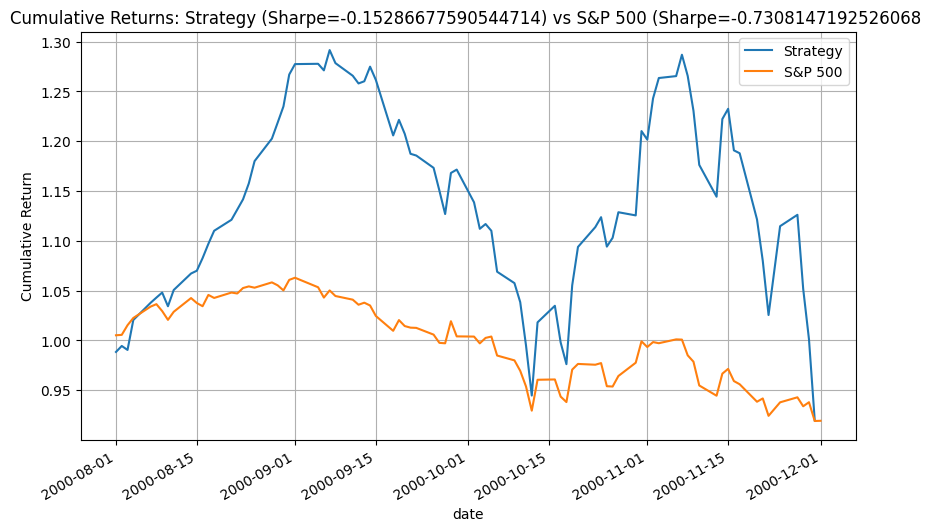

In [43]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[7].to_timestamp()
sp_ret = sp_ret.loc[strat_start:'2000-12-01']

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(combined_returns.shape[0]) * (combined_returns.mean() / combined_returns.std())
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()